# Final Project: Reddit Sentiment vs Stock Price Movement

In this project, we analyze whether sentiment from Reddit posts about stocks can help predict next-day stock price movement.

We used the [Unlocking Stock Market Insights with Reddit User Behavior](https://www.kaggle.com/datasets/thedevastator/unlocking-stock-market-insights-with-reddit-user) dataset from Kaggle, which contains posts from the r/stocks subreddit between November and December 2022. Each post includes a title, body, timestamp, and number of upvotes.

For sentiment analysis, we used the **VADER** sentiment analyzer, which is specifically designed for social media text. We originally explored using TextBlob, but pivoted to VADER due to its stronger performance on informal language and social media related slang.

For stock price data, we used the **Yahoo Finance API** via the yfinance Python library.

---

### Hypothesis
**Higher Reddit sentiment on a given day (especially for posts that mention a stock directly) is associated with a higher stock price movement the next day.**

---

### Results

For TSLA, our analysis showed a correlation of about -0.0057, which indicates that there is basically no linear relationship between overall Reddit sentiment and next-day price change. When we isolated posts that specifically mentioned TSLA, the correlation jumped to +0.58. We repeated this for GME, AAPL, AMC, PLTR, and other companies and found that company-specific sentiment usually gave us a stronger correlation than overall sentiment (strength and direction of this correlation varied by stock).

---

### Interpretation

These findings challenge our hypothesis that public sentiment on Reddit helps predict next-day stock performance. Filtering for stock-specific posts usually makes sentiment more focused and sometimes more aligned with price changes (though this might be because of the positively skewed sentiment for specific tickers).

Some possible reasons that we got these results might be because:
- The dataset only spans ~6 weeks (Nov–Dec 2022)
- Other factors like the economy or news may dominate stock movement and be a better predictor
- VADER may not be a great indicator of sentiment (might be overestimating or misinterpreting posts)





## Instructions
Please upload `stocks.csv` using the **Files** tab on the left. You can download the csv file from the Kaggle link above or simply use the file we shared.

Once uploaded, the notebook will work as expected.

## 1. Load and Clean Reddit Dataset
We load the Reddit post data, combine the title and body, clean the text, and prepare it for sentiment analysis.


In [ ]:
# install packages
!pip install yfinance vaderSentiment seaborn

import pandas as pd
import re

df = pd.read_csv('stocks.csv')

df['full_text'] = (df['title'].fillna('') + ' ' + df['body'].fillna('')).str.strip()

def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    return text.strip()

df['cleaned_text'] = df['full_text'].apply(clean_text)


## 2. Sentiment Analysis using VADER
We apply VADER to score each Reddit post for sentiment.


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
def get_sentiment(text):
    return analyzer.polarity_scores(text)['compound']

df['sentiment'] = df['cleaned_text'].apply(get_sentiment)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date


Below were just some test print statements we included to make sure that the sentiment analyzer was printing reasonable values.

In [ ]:
print("Mean sentiment:", df['sentiment'].mean())
print("Min sentiment:", df['sentiment'].min())
print("Max sentiment:", df['sentiment'].max())


Mean sentiment: 0.28737676419965574
Min sentiment: -0.9824
Max sentiment: 0.9996


## 3. Aggregate Overall Sentiment by Day
We group posts by date and calculate the average sentiment and post volume.


In [ ]:
daily_sentiment = df.groupby('date').agg({
    'sentiment': 'mean',
    'cleaned_text': 'count'
}).reset_index()

daily_sentiment.columns = ['date', 'avg_sentiment', 'post_volume']


## 4. Aggregate Company-Specific Reddit Sentiment

To improve on our original analysis (which used all Reddit posts), we isolated and only aggregated sentiment for posts that directly mention a specific stock.

We used simple regex to match either the company name or its ticker to find relevant posts. We then compute the average sentiment per day, but just for these posts.

This gives us a more focused and meaningful sentiment for our chosen stock.

In [ ]:
# change ticker to test different stocks
ticker = 'TSLA'
company_name = 'Tesla'

pattern = f"{ticker}|{company_name}"
df['mentions_ticker'] = df['full_text'].str.contains(pattern, case=False, regex=True)

company_daily_sentiment = df[df['mentions_ticker']].groupby('date').agg({
    'sentiment': 'mean',
    'cleaned_text': 'count'
}).reset_index()
company_daily_sentiment.columns = ['date', 'ticker_avg_sentiment', 'ticker_post_volume']


## 5. Pull Stock Price Data

We use the `yfinance` library to get historical stock data our chosen company. We then calculate the next-day percentage change in the stock's closing price.

Since `yfinance` sometimes returns data with MultiIndex for column headers, we had to research this and then flatten the columns before getting the daily closing prices.

Then, we just add a label column: 1 for price up, 0 for price down.

In [ ]:
import yfinance as yf

start_date = str(daily_sentiment['date'].min())
end_date = str(daily_sentiment['date'].max())

stock_data = yf.download(ticker, start=start_date, end=end_date)

# flatten columns if MultiIndex
if isinstance(stock_data.columns, pd.MultiIndex):
    stock_data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in stock_data.columns]

stock_data = stock_data.reset_index()
stock_data['date'] = pd.to_datetime(stock_data['Date']).dt.date

close_col = [col for col in stock_data.columns if 'Close' in col][0]
stock_data = stock_data[['date', close_col]]
stock_data.rename(columns={close_col: 'Close'}, inplace=True)

stock_data['next_day_pct_change'] = stock_data['Close'].pct_change().shift(-1)
stock_data['label'] = stock_data['next_day_pct_change'].apply(lambda x: 1 if x > 0 else 0)


[*********************100%***********************]  1 of 1 completed


## 6. Join Reddit Sentiment with Stock Price Data
We align the daily sentiment with the corresponding stock data by date.

First, we merge the overall daily Reddit sentiment with the stock price data.  Then, we merge in the company-specific sentiment. We drop any rows that are missing sentiment or price change.



In [ ]:
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date']).dt.date
stock_data['date'] = pd.to_datetime(stock_data['date']).dt.date

daily_sentiment = daily_sentiment.reset_index(drop=True)
stock_data = stock_data.reset_index(drop=True)

merged = pd.merge(daily_sentiment, stock_data, on='date')
merged = pd.merge(merged, company_daily_sentiment[['date', 'ticker_avg_sentiment']], on='date', how='left') # merge company-specific sentiment with main dataset
merged.dropna(subset=['avg_sentiment', 'next_day_pct_change'], inplace=True)
merged.head()


,date,avg_sentiment,post_volume,Close,next_day_pct_change,label,ticker_avg_sentiment
0,2022-11-07,0.611333,3,197.080002,-0.029328,0,NaN
1,2022-11-08,0.568520,25,191.300003,-0.071668,0,0.337167
2,2022-11-09,0.272204,23,177.589996,0.073934,1,0.389320
3,2022-11-10,0.578630,20,190.720001,0.027527,1,0.257900
4,2022-11-11,0.403260,25,195.970001,-0.025616,0,0.158625


## 7. Visualize Sentiment vs Stock Movement
We plot the daily overall Reddit sentiment and the company-specific Reddit sentiment against the next day's stock price change.


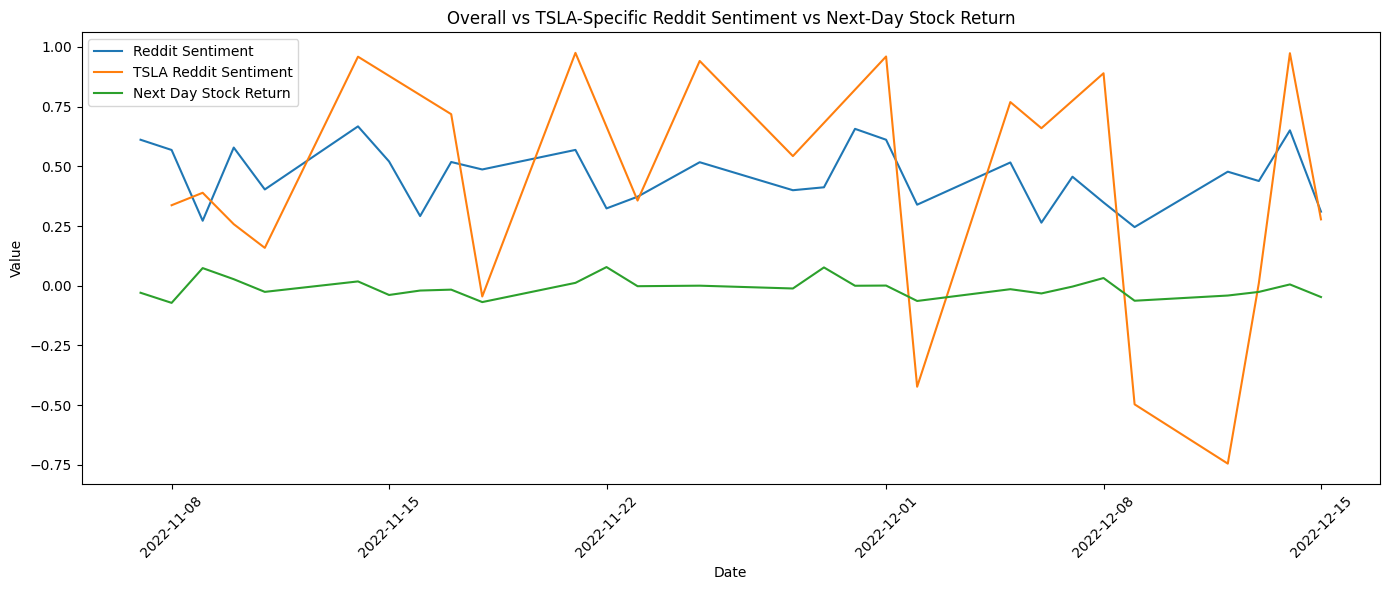

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
sns.lineplot(data=merged, x='date', y='avg_sentiment', label='Reddit Sentiment')
sns.lineplot(data=merged, x='date', y='ticker_avg_sentiment', label=f'{ticker} Reddit Sentiment')
sns.lineplot(data=merged, x='date', y='next_day_pct_change', label='Next Day Stock Return')
plt.title(f"Overall vs {ticker}-Specific Reddit Sentiment vs Next-Day Stock Return")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 8. Correlation Analysis

To test our hypothesis, we wanted to see if there's a relationship between Reddit sentiment for a given day and how the stock performs the following day.

We used a simple correlation formula (`np.corrcoef`) in Python to calculate how strongly the two values move together:
- `avg_sentiment`: average Reddit sentiment for the day
- `next_day_pct_change`: how much the stock's closing price changes on the next day (in percentages)

A correlation close to +1 shows positive sentiment usually leads to price increases. A correlation close to 0 means no visible relationship. A negative value would imply that more positive sentiment might actually be followed by price drops.

We then repeated the same calculation using only the sentiment from posts that directly mention the company (like posts that contain “TSLA” or “Tesla”). This allowed us to compare whether company-specific sentiment is better correlated with stock movement.



In [ ]:
import numpy as np

corr = np.corrcoef(merged['avg_sentiment'], merged['next_day_pct_change'])[0, 1]
print("Correlation between Reddit sentiment and next-day stock return:", corr)

merged_ticker = merged.dropna(subset=['ticker_avg_sentiment'])
corr_company = np.corrcoef(merged_ticker['ticker_avg_sentiment'], merged_ticker['next_day_pct_change'])[0, 1]
print(f"Correlation between {ticker} Reddit sentiment and next-day stock return:", corr_company)


Correlation between Reddit sentiment and next-day stock return: -0.005741037572853969
Correlation between TSLA Reddit sentiment and next-day stock return: 0.5815613973411842


## 9. Scatter Plot with Trendline
We visualize the relationship between sentiment and stock price change using two scatter plots.

The first plot shows correlation between overall Reddit sentiment and stock price change. The second plot shows correlation between company-specific sentiment and stock price change.


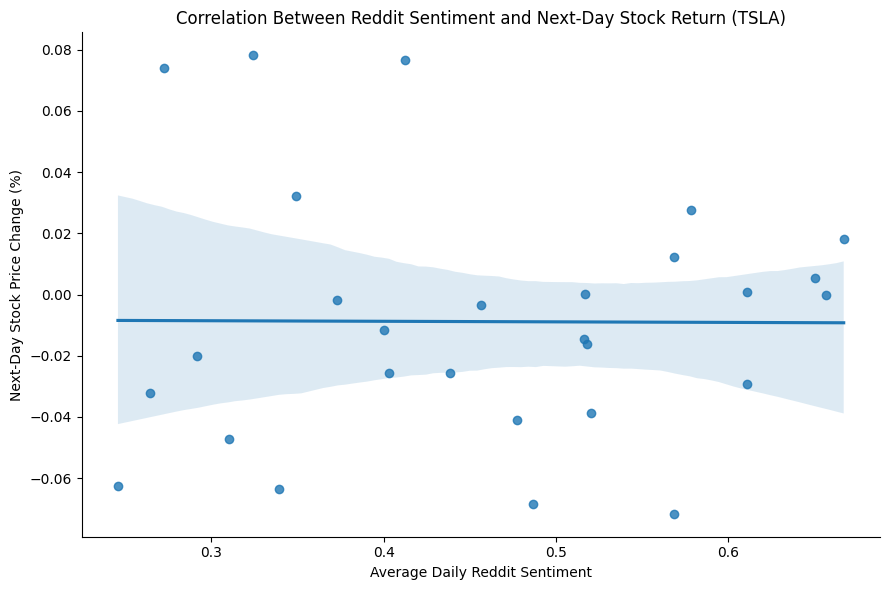

In [ ]:
sns.lmplot(data=merged, x='avg_sentiment', y='next_day_pct_change', height=6, aspect=1.5)
plt.title("Correlation Between Reddit Sentiment and Next-Day Stock Return (TSLA)")
plt.xlabel("Average Daily Reddit Sentiment")
plt.ylabel("Next-Day Stock Price Change (%)")
plt.tight_layout()
plt.show()

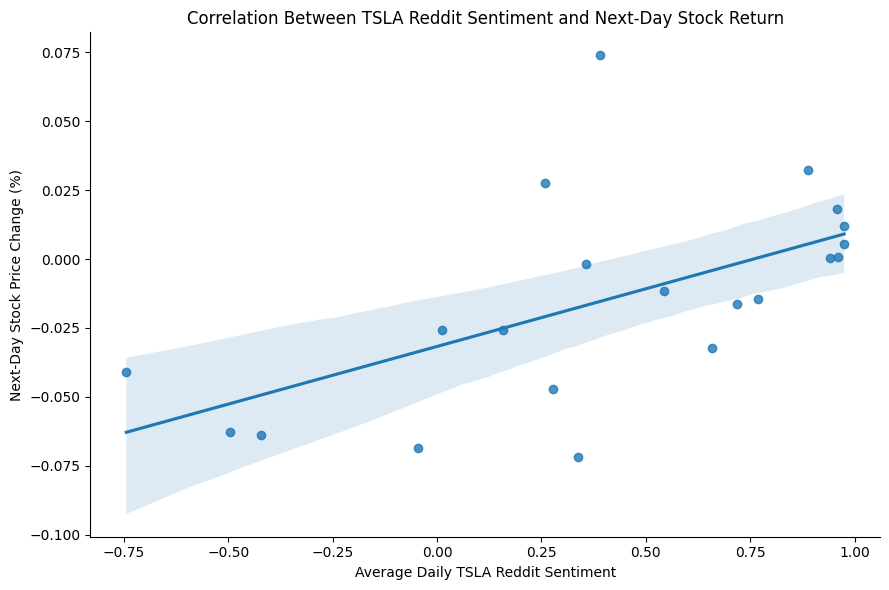

In [ ]:
sns.lmplot(data=merged, x='ticker_avg_sentiment', y='next_day_pct_change', height=6, aspect=1.5)
plt.title(f"Correlation Between {ticker} Reddit Sentiment and Next-Day Stock Return")
plt.xlabel(f"Average Daily {ticker} Reddit Sentiment")
plt.ylabel("Next-Day Stock Price Change (%)")
plt.tight_layout()
plt.show()